# Including Radioactive Isotopes in NuPyCEE

Prepared by: Benoit Côté

This notebook describe the radioactive isotope implementation in NuPyCEE and shows how to run a SYGMA and OMEGA with radioactive yields.

In [1]:
# Import python modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Import the NuPyCEE codes
from NuPyCEE import sygma
from NuPyCEE import omega

## 1. Input Parameters

The inputs that need to be provided to activate the radioactive option are:

- the list of selected radioactive isotopes,
- the radioactive yield tables.

The list of isotopes is declared in the **yield_tables/decay_info.txt** file and can be modified prior any simulation.  The radioactive yields are found (or need to be added) in the **yield_tables/** folder.  Each stable yield table can have their associated radioactive yield table:

- **Massive and AGB stars**
 - Stable isotopes: *table*
 - Radioactive isotopes: *table_radio*
- **Type Ia supernovae**
 - Stable isotopes: *sn1a_table*
 - Radioactive isotopes: *sn1a_table_radio*
- **Neutron star mergers**
 - Stable isotopes: *nsmerger_table*
 - Radioactive isotopes: *nsmerger_table_radio*
- Etc..
 
Each enrichment source can be activated independently by providing its input radioactive yield table.  The radioactive yield table file format needs to be identical to its stable counterpart.

**Warning:** Radioactive isotopes will decay into stable isotopes.  When using radioactive yields, please make sure that the stable yields do not include the decayed isotopes already.

## 2. Single Decay Channel (Default Option)

If the radioactive isotopes you selected have only one decay channel, you can use the default decay option, which uses the following exponential law,

$N_r(t)=N_r(t_0)\,\mathrm{exp}\left[\frac{-(t-t_0)}{\tau}\right],$

$\tau=\frac{T_{1/2}}{\mathrm{ln}(2)},$

where $t_0$ is the reference time where the number of radioactive isotopes was equal to $N_0$. $T_{1/2}$ is the half-life of the isotope, which needs to be specified in yield_tables/decay_info.txt.  The decayed product will be added to the corresponding stable isotope, as defined in yield_tables/decay_info.txt.

### Example with Al-26

Below, a SYGMA simulation is ran with no star formation to better isolate the decay process.  Here we choose Al-26 as an example, which decays into Mg-26.

In [2]:
# Number of timesteps in the simulaton.
# See https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Timesteps_size_management.ipynb
special_timesteps = -1
nb_dt = 100
tend = 2.0e6
dt = tend / float(nb_dt)

# No star formation.
no_sf = True

# Dummy neutron star merger yields to activate the radioactive option.
nsmerger_table_radio = 'yield_tables/extra_table_radio_dummy.txt'

In [3]:
# Add 1 Msun of radioactive Al-26 in the gas.
# The indexes of this array reflect the order seen in the yield_tables/decay_file.txt file
# Index 0, 1, 2 --> Al-26, K-40, U-238
ism_ini_radio = [1.0, 0.0, 0.0]

#### Run SYGMA

In [4]:
# Run SYGMA (or in this case, the decay process)
s = sygma.sygma(iniZ=0.02, no_sf=no_sf, ism_ini_radio=ism_ini_radio,\
                special_timesteps=special_timesteps, tend=tend, dt=dt,\
                decay_file='yield_tables/decay_file.txt', nsmerger_table_radio=nsmerger_table_radio)

SYGMA run in progress..
   SYGMA run completed - Run time: 0.13s


In [5]:
# Get the Al-26 (radioactive) and Mg-26 (stable) indexes in the gas arrays
i_Al_26 = s.radio_iso.index('Al-26')
i_Mg_26 = s.history.isotopes.index('Mg-26')

# Extract the evolution of these isotopes as a function of time
Al_26 = np.zeros(s.nb_timesteps+1)
Mg_26 = np.zeros(s.nb_timesteps+1)
for i_t in range(s.nb_timesteps+1):
    Al_26[i_t] = s.ymgal_radio[i_t][i_Al_26]
    Mg_26[i_t] = s.ymgal[i_t][i_Mg_26]

#### Plot results

<IPython.core.display.Javascript object>


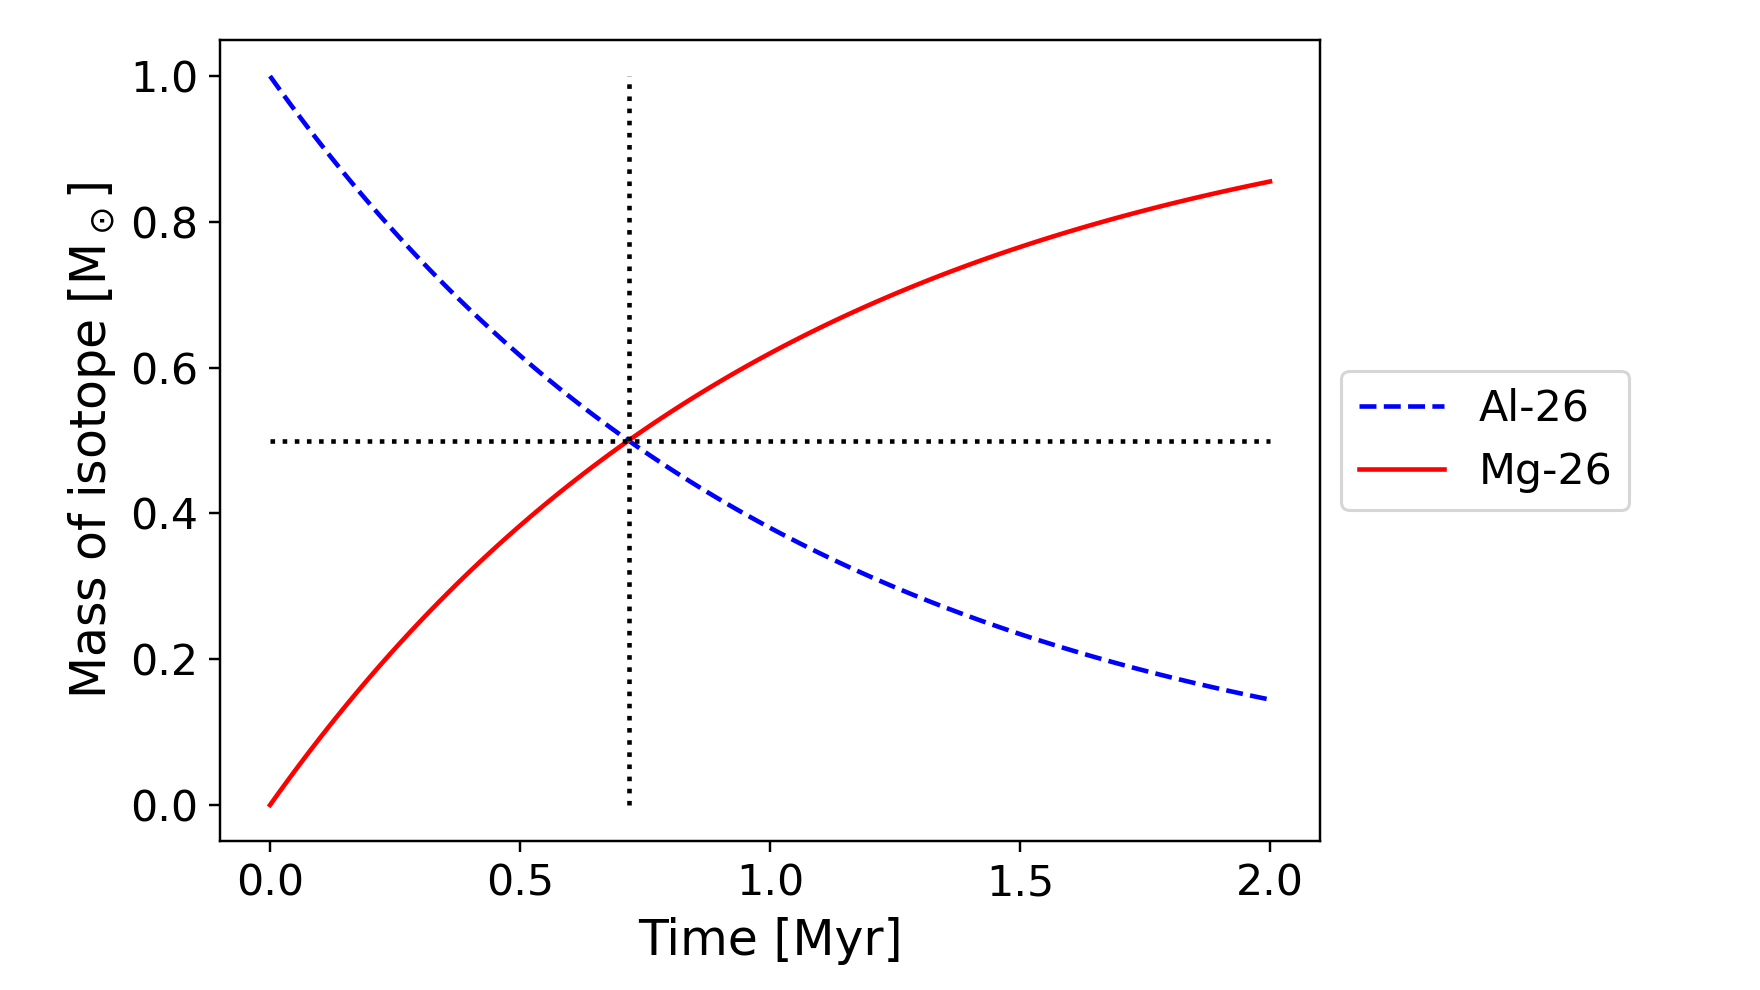

In [7]:
# Plot the evolution of Al-26 and Mg-26
%matplotlib nbagg
plt.figure(figsize=(8,4.5))
plt.plot( np.array(s.history.age)/1e6, Al_26, '--b', label='Al-26' )
plt.plot( np.array(s.history.age)/1e6, Mg_26, '-r',  label='Mg-26' )
plt.plot([0,2.0], [0.5,0.5], ':k')
plt.plot([0.717,0.717], [0,1], ':k')

# Labels and fontsizes
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Mass of isotope [M$_\odot$]', fontsize=16)
plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.96)
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(right=0.75)
matplotlib.rcParams.update({'font.size': 14.0})

## 3. Multiple Decay Channels

If the radioactive isotopes you selected have more than one decay channel, you need to use the provided decay module.  This option can be activated by adding **use_decay_module=True** in the list of parameters when creating an instance of SYGMA and OMEGA.  When using the decay module, the yield_tables/decay_file.txt file still needs to be provided as an input to define which radioactive isotopes are selected for the calculation.

### Example with K-40

Below we still run a SYGMA simulation with no star formation to better isolate the decay process.  A fraction of K-40 decays into Ca-40, and another fraction decays into Ar-40.

#### Run SYGMA

In [8]:
# Add 1 Msun of radioactive K-40 in the gas.
# The indexes of this array reflect the order seen in the yield_tables/decay_file.txt file
# Index 0, 1, 2 --> Al-26, K-40, U-238
ism_ini_radio = [0.0, 1.0, 0.0]

In [9]:
# Number of timesteps in the simulaton.
# See https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Timesteps_size_management.ipynb
special_timesteps = -1
nb_dt = 100
tend = 5.0e9
dt = tend / float(nb_dt)

In [10]:
# Run SYGMA (or in this case, the decay process)
# with the decay module
s = sygma.sygma(iniZ=0.0, sfr=sfr, starbursts=starbursts, ism_ini_radio=ism_ini_radio,\
                special_timesteps=special_timesteps, tend=tend, dt=dt,\
                decay_file='yield_tables/decay_file.txt', nsmerger_table_radio=nsmerger_table_radio,\
                use_decay_module=True, radio_refinement=1)

SYGMA run in progress..
   SYGMA run completed - Run time: 1.15s


In [11]:
# Get the K-40 (radioactive) and Ca-40 and Ar-40 (stable) indexes in the gas arrays
i_K_40 = s.radio_iso.index('K-40')
i_Ca_40 = s.history.isotopes.index('Ca-40')
i_Ar_40 = s.history.isotopes.index('Ar-40')

# Extract the evolution of these isotopes as a function of time
K_40  = np.zeros(s.nb_timesteps+1)
Ca_40 = np.zeros(s.nb_timesteps+1)
Ar_40 = np.zeros(s.nb_timesteps+1)
for i_t in range(s.nb_timesteps+1):
    K_40[i_t]  = s.ymgal_radio[i_t][i_K_40]
    Ca_40[i_t] = s.ymgal[i_t][i_Ca_40]
    Ar_40[i_t] = s.ymgal[i_t][i_Ar_40]

<IPython.core.display.Javascript object>


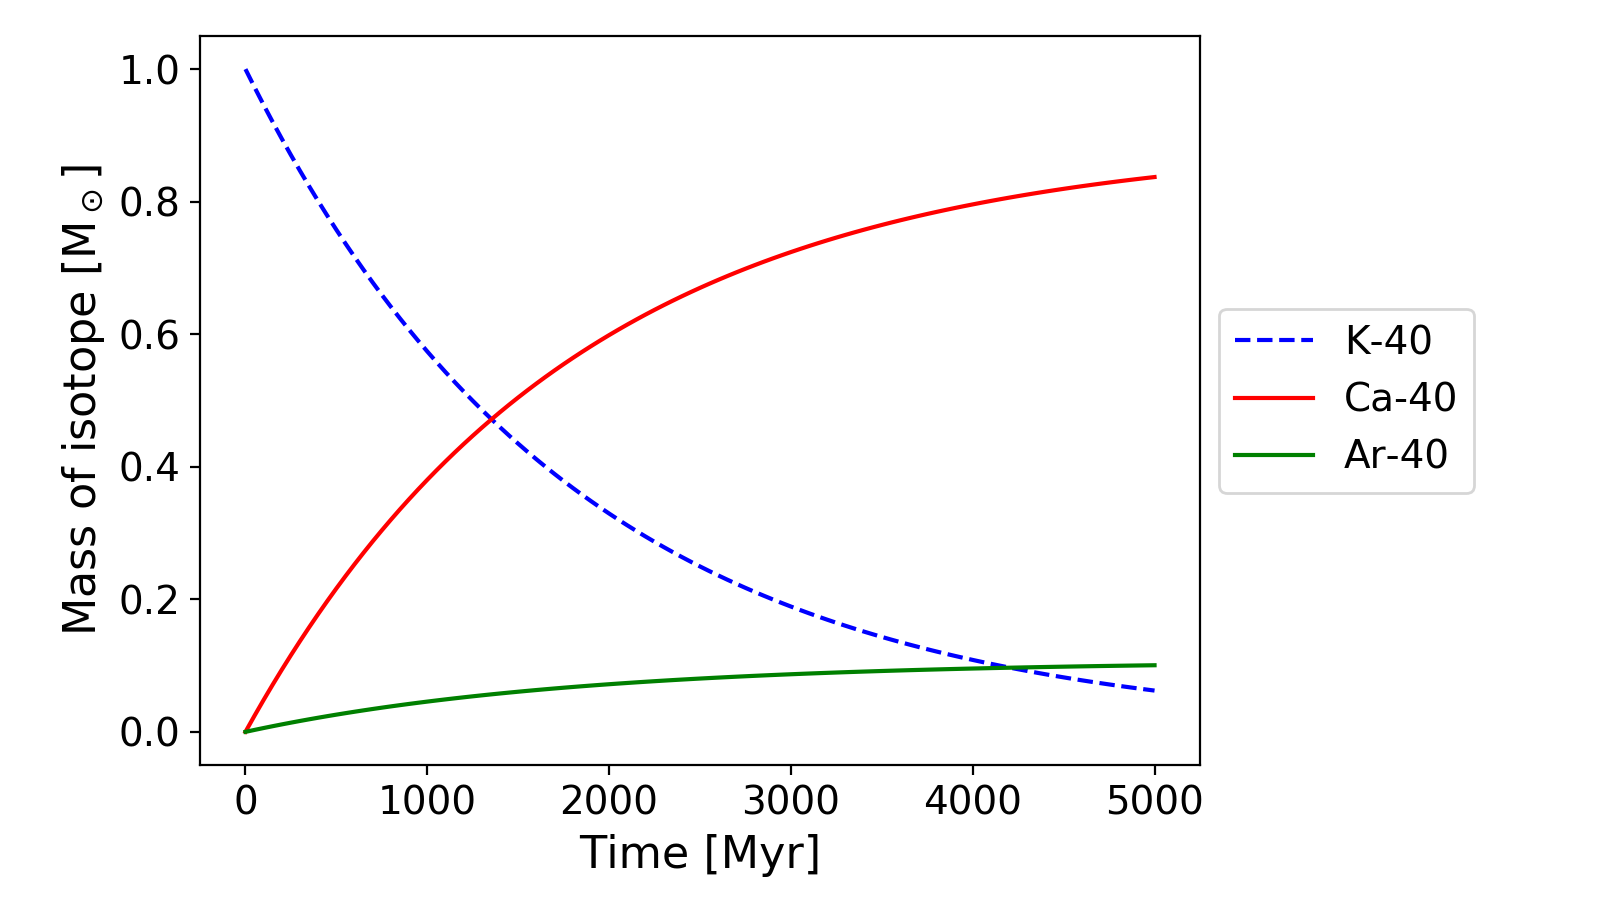

In [12]:
# Plot the evolution of Al-26 and Mg-26
%matplotlib nbagg
plt.figure(figsize=(8,4.5))
plt.plot( np.array(s.history.age)/1e6, K_40, '--b', label='K-40' )
plt.plot( np.array(s.history.age)/1e6, Ca_40, '-r', label='Ca-40' )
plt.plot( np.array(s.history.age)/1e6, Ar_40, '-g', label='Ar-40' )

# Labels and fontsizes
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Mass of isotope [M$_\odot$]', fontsize=16)
plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.96)
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(right=0.75)
matplotlib.rcParams.update({'font.size': 14.0})

### Example with U-238

In [13]:
# Add 1 Msun of radioactive U-238 in the gas.
# The indexes of this array reflect the order seen in the yield_tables/decay_file.txt file
# Index 0, 1, 2 --> Al-26, K-40, U-238
ism_ini_radio = [0.0, 0.0, 1.0]

In [14]:
# Number of timesteps in the simulaton.
# See https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Timesteps_size_management.ipynb
special_timesteps = -1
nb_dt = 100
tend = 5.0e9
dt = tend / float(nb_dt)

In [15]:
# Run SYGMA (or in this case, the decay process)
# with the decay module
s = sygma.sygma(iniZ=0.0, sfr=sfr, starbursts=starbursts, ism_ini_radio=ism_ini_radio,\
                special_timesteps=special_timesteps, tend=tend, dt=dt,\
                decay_file='yield_tables/decay_file.txt', nsmerger_table_radio=nsmerger_table_radio,\
                use_decay_module=True, radio_refinement=1)

SYGMA run in progress..
   SYGMA run completed - Run time: 3.28s


In the case of U-238, there are many isotopes that are resulting from the multiple decay channels. Those new radioactive isotopes are added automatically in the list of isotopes in NuPyCEE.

In [16]:
print(s.radio_iso)

['Al-26', 'K-40', 'U-238', 'NN-1', 'Ga-78', 'Ga-79', 'Ga-80', 'Ga-81', 'Ga-82', 'Ga-83', 'Ga-84', 'Ga-85', 'Ge-78', 'Ge-79', 'Ge-80', 'Ge-81', 'Ge-82', 'Ge-83', 'Ge-84', 'Ge-85', 'Ge-86', 'Ge-87', 'Ge-88', 'Ge-89', 'As-80', 'As-81', 'As-82', 'As-83', 'As-84', 'As-85', 'As-86', 'As-87', 'As-88', 'As-89', 'As-90', 'As-91', 'Se-81', 'Se-83', 'Se-84', 'Se-85', 'Se-86', 'Se-87', 'Se-88', 'Se-89', 'Se-90', 'Se-91', 'Se-92', 'Se-93', 'Se-94', 'Br-83', 'Br-84', 'Br-85', 'Br-86', 'Br-87', 'Br-88', 'Br-89', 'Br-90', 'Br-91', 'Br-92', 'Br-93', 'Br-94', 'Br-95', 'Br-96', 'Br-97', 'Kr-85', 'Kr-87', 'Kr-88', 'Kr-89', 'Kr-90', 'Kr-91', 'Kr-92', 'Kr-93', 'Kr-94', 'Kr-95', 'Kr-96', 'Kr-97', 'Kr-98', 'Kr-99', 'Kr-100', 'Rb-86', 'Rb-88', 'Rb-89', 'Rb-90', 'Rb-91', 'Rb-92', 'Rb-93', 'Rb-94', 'Rb-95', 'Rb-96', 'Rb-97', 'Rb-98', 'Rb-99', 'Rb-100', 'Rb-101', 'Sr-89', 'Sr-90', 'Sr-91', 'Sr-92', 'Sr-93', 'Sr-94', 'Sr-95', 'Sr-96', 'Sr-97', 'Sr-98', 'Sr-99', 'Sr-100', 'Sr-101', 'Sr-102', 'Sr-103', 'Sr-104', 'Sr